In [1]:
import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, TensorDataset

from torch.optim.lr_scheduler import ReduceLROnPlateau

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime

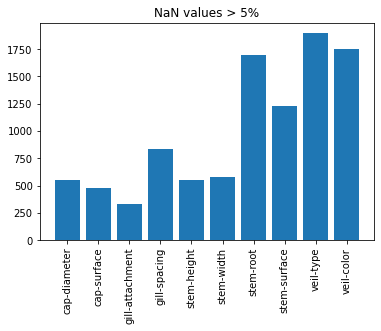

In [2]:
#################### Pre processing data ####################

def read_data():
    train_data = pd.read_csv(os.getcwd()+"/train_data.csv")
    test_data = pd.read_csv(os.getcwd()+"/test_data.csv")
    return train_data, test_data
    
log = [f"====={datetime.datetime.now().strftime('%Y-%d-%m %H:%M')}====="]
def save_log(logged_data):
    with open("logfile.txt", "a") as logfile:
        logfile.writelines(line + '\n' for line in logged_data)
        logfile.write("")

def get_data(dataframe):
    [print(f"{col}: {train_data[col].dtypes}, {set(train_data[col])}") for col in train_data.columns]

def apply_cleaning(dataframe, cols_to_remove=["id", "poisonous"]):
    """Remove useless data"""
    for col in cols_to_remove:
        if col in dataframe.columns:
            dataframe = dataframe.drop(columns=[col])
    log.append(f"apply_cleaning() removed {cols_to_remove}")
    return dataframe

def apply_dummies(dataframe, dummy_nan = True):
    """Categorical data to unique column with 0 or 1"""
    old_cols = len(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, dummy_na=dummy_nan)# generate dummy data
    #dataframe = pd.concat([dataframe, dummy_data], axis=1)# join dataframe and dummy data 
    
    log.append(f"apply_dummies(dummy_na={dummy_nan}) features {old_cols} -> {len(dataframe.columns)}")
    return dataframe

def apply_fillna(dataframe):
    """Replace numeric nan values with 0"""
    numeric_columns = [col for col in dataframe.columns if dataframe[col].dtype != "object"]
    log.append(f"apply_fillna() applied to {numeric_columns}")
    dataframe[numeric_columns] = dataframe[numeric_columns].fillna(0) 
    return dataframe

def apply_standardization(dataframe):
    """Apply standardization (x-mean)/std"""
    # fail check for non numeric data
    numeric_columns = [col for col in dataframe.columns if dataframe[col].dtype != "object"]
    numeric_dataframe = dataframe[numeric_columns]

    # applies column-wise standardization via numpy
    numeric_dataframe = (numeric_dataframe - numeric_dataframe.mean()) / numeric_dataframe.std()

    dataframe[numeric_columns] = numeric_dataframe

    log.append(f"apply_standardization()")
    return dataframe

def check_nan_data(dataframe, percent = 5, remove = False):
    nan_data = {col: dataframe[col].isna().sum() for col in dataframe.columns}
    # get only the cols with > 5% nan data
    nan_data = {key: value for key,value in nan_data.items() if value > max(nan_data.values())*percent/100}


    plt.bar(nan_data.keys(),nan_data.values())
    plt.title(f"NaN values > {percent}%")
    plt.xticks(rotation='vertical')
    plt.show()
    
    #not_nan_data = {key: len(dataframe[key]) - value for key,value in nan_data.items()}
    #plt.bar(not_nan_data.keys(), not_nan_data.values())
    #plt.xticks(rotation='vertical')
    #plt.show()

    if remove:
        log.append(f"check_nan_data() removed {len(nan_data.keys())} columns with {sum([len(dataframe[col]) - nan_data[col] for col in nan_data.keys()])} useful entries")
        dataframe = dataframe.drop(columns=nan_data.keys())
        return dataframe
    else:
        return nan_data.keys()

train_data, test_data = read_data()
labels = train_data["poisonous"]
# 1 - poisonous, 0 - not poisonous
labels = labels.apply(lambda x: 1 if x =="y" else 0) 

train_data = apply_cleaning(train_data)

check_nan_data(train_data)
# remove cols with > 50% nan values
#train_data = check_nan_data(train_data, percent = 70, remove = True) #degrades acc

train_data = apply_standardization(train_data)
train_data = apply_fillna(train_data)
train_data = apply_dummies(train_data, dummy_nan = True)

save_log(log)
test_data = apply_cleaning(test_data)
#test_data = check_nan_data(test_data, percent = 70, remove = True) #degrades acc
test_data = apply_standardization(test_data)
test_data = apply_fillna(test_data)
test_data = apply_dummies(test_data, dummy_nan = True)

log = []

In [3]:
# Neural net
class Net(Module):
    # bottleneck model 
    def __init__(self, input_features, hidden_size, dropout_chance = 0.4):
        super().__init__()
        layers = [
            nn.Linear(input_features, hidden_size*15),
            nn.Dropout(dropout_chance),
            nn.LeakyReLU(),
            nn.Linear(hidden_size*15, hidden_size*10),
            nn.LeakyReLU(),
            nn.Linear(hidden_size*10, hidden_size*5),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.Linear(hidden_size*5, 1),
            nn.LeakyReLU(),
        ]
        self.layers = nn.Sequential(*layers)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return self.sigmoid(x)

In [4]:
###################### Constants #######################
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 20
learning_rate = 0.0001
weight_decay = 0.0001

dropout = 0.3

epochs = 120

in_features = len(train_data.columns)
hidden_size = in_features

model = Net(in_features, hidden_size, dropout).to(device)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

log.append(f"Model: {model}")
log.append(f"Using {loss_function}")
log.append(f"Using {optimizer} ")

##################### Set up loaders #################
validation_split_index = int(0.9*len(train_data))
training_dataset = TensorDataset(
        torch.from_numpy(train_data[:validation_split_index].to_numpy(np.float32)), 
        torch.from_numpy(labels[:validation_split_index].to_numpy(np.float32))
    )

validation_dataset = TensorDataset(
        torch.from_numpy(train_data[validation_split_index:].to_numpy(np.float32)), 
        torch.from_numpy(labels[validation_split_index:].to_numpy(np.float32))
    )

testing_dataset = torch.from_numpy(test_data.to_numpy(np.float32))

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle = False)

log.append(f"Split data into {validation_split_index} entries for training and {len(train_data)- validation_split_index} entries for validation.")
save_log(log)
log = []

In [5]:
################ Train model ###################
def train_model(model, epochs, loss_function, optimizer, train_loader, valid_loader, log = [], use_scheduler = False):
    train_loss = []
    valid_loss = []
    train_acc =  []
    valid_acc =  []

    if use_scheduler:
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
        scheduler = ReduceLROnPlateau(optimizer, 'min', verbose = True, cooldown = 5, factor=0.5)
        log.append(f"Using ReduceLROnPlateau scheduler with cooldown:{scheduler.cooldown}, factor:{scheduler.factor}")

        
    for epoch in range(epochs):
        model.train()
        t_loss, v_loss = 0,0
        t_acc, v_acc = 0,0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device).unsqueeze(1)# unsqueeze to add empty dim

            output = model(x)
            loss = loss_function(output,y) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            t_acc += (sum(output.round()==y)/len(output)).item()/len(train_loader) # get acc
            t_loss += loss/len(train_loader) # average training loss for the epoch

        train_loss.append(t_loss.cpu().detach())
        train_acc.append(t_acc)

        model.eval()
        with torch.no_grad():
            for x,y in valid_loader:
                x,y = x.to(device), y.to(device).unsqueeze(1) # unsqueeze to add dim
                output = model(x)
                loss = loss_function(output,y) 
        
                v_acc += (sum(output.round()==y)/len(output)).item()/len(valid_loader) # get acc
                v_loss += loss/len(valid_loader) # average validation loss for the epoch

        valid_acc.append(v_acc)
        valid_loss.append(v_loss.cpu().detach())
        if epoch%5==0:
            print(f"Tacc: {train_acc[-1]:.2f}, Vacc: {valid_acc[-1]:.2f} Tloss: {train_loss[-1]:.2f} Vloss: {valid_loss[-1]:.2f}")

        # reduce lr when a plateau is hit
        if use_scheduler:
            scheduler.step(valid_loss[-1])

    plt.plot(train_loss, "b-")
    plt.plot(valid_loss, "g-")
    plt.plot(train_acc, "b--", alpha = 0.7)
    plt.plot(valid_acc, "g--", alpha = 0.7)
    plt.legend(["Train loss","Valid loss", f"Train acc {train_acc[-1]*100:.1f}", f"Valid acc {valid_acc[-1]*100:.1f}"])
    plt.show()


    if use_scheduler:
        log[-1] += f", Ending lr = {optimizer.state_dict()['param_groups'][0]['lr']}"

    log.append(f"Train_loss final: {train_loss[-1]:.3f}, ACC: {train_acc[-1]*100:.1f}%")
    log.append(f"Valid_loss final: {valid_loss[-1]:.3f}, ACC: {valid_acc[-1]*100:.1f}%")
    save_log(log)
    log = []

################ Generating results #################
def test_model(model, test_laoder):
    model.eval()
    results = []
    with torch.no_grad():
        for data in test_laoder:
            data = data.to(device)
            output = model(data).squeeze()
            output = output.round()
            results.extend(output.cpu().detach().tolist())

    print(results[:30])
    results = ["y" if results[i] == 1.0  else "n" for i in range(len(results))]
    print(results[:30])
    print(f"[y: {results.count('y')}/n: {results.count('n')}]")

    results_table = pd.DataFrame({"id":list(range(1, len(results)+1)),"poisonous":results})
    results_table.to_csv(f"{os.getcwd()}/results_table.csv", index=False)
    #results_table.head(20)

Tacc: 0.59, Vacc: 0.70 Tloss: 0.65 Vloss: 0.58
Tacc: 0.91, Vacc: 0.87 Tloss: 0.37 Vloss: 0.40
Tacc: 0.94, Vacc: 0.91 Tloss: 0.35 Vloss: 0.36
Tacc: 0.96, Vacc: 0.94 Tloss: 0.31 Vloss: 0.35
Tacc: 0.96, Vacc: 0.90 Tloss: 0.26 Vloss: 0.31
Tacc: 0.94, Vacc: 0.82 Tloss: 0.30 Vloss: 0.28
Tacc: 0.96, Vacc: 0.92 Tloss: 0.17 Vloss: 0.17
Tacc: 0.97, Vacc: 0.92 Tloss: 0.13 Vloss: 0.12
Tacc: 0.98, Vacc: 0.96 Tloss: 0.11 Vloss: 0.07
Tacc: 0.97, Vacc: 0.93 Tloss: 0.05 Vloss: 0.12
Tacc: 0.99, Vacc: 0.97 Tloss: 0.25 Vloss: 1.56
Epoch 00052: reducing learning rate of group 0 to 5.0000e-05.
Tacc: 0.99, Vacc: 0.97 Tloss: 0.08 Vloss: 0.06
Tacc: 0.99, Vacc: 0.96 Tloss: 0.02 Vloss: 0.05
Tacc: 0.99, Vacc: 0.96 Tloss: 0.02 Vloss: 0.05
Tacc: 0.99, Vacc: 0.98 Tloss: 0.02 Vloss: 0.04
Tacc: 0.99, Vacc: 0.97 Tloss: 0.01 Vloss: 0.06
Epoch 00076: reducing learning rate of group 0 to 2.5000e-05.
Tacc: 1.00, Vacc: 0.97 Tloss: 0.01 Vloss: 0.05
Tacc: 1.00, Vacc: 0.97 Tloss: 0.01 Vloss: 0.05
Tacc: 1.00, Vacc: 0.97 Tloss: 

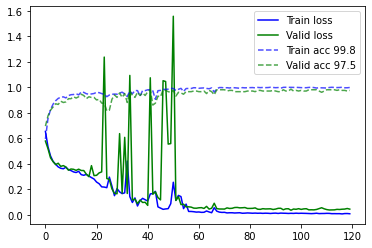

["99.8%", "0.008", "97.5%", "0.044"]


In [6]:
train_model(model, epochs, loss_function, optimizer, training_loader, validation_loader, log, use_scheduler=True)

In [10]:
test_model(model,testing_loader)

[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
['y', 'y', 'n', 'y', 'n', 'n', 'y', 'y', 'y', 'n', 'y', 'y', 'y', 'n', 'n', 'y', 'n', 'n', 'y', 'y', 'n', 'y', 'y', 'n', 'y', 'y', 'n', 'n', 'n', 'y']
[y: 1626/n: 1374]


In [8]:
#torch.save(model.state_dict(), f"{os.getcwd()}/model.pt")

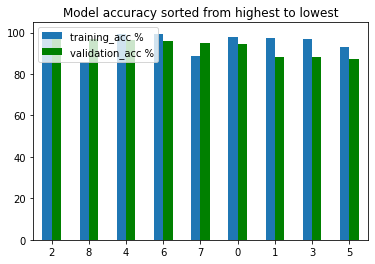

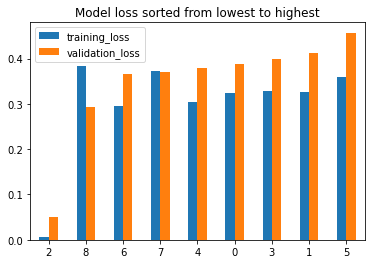

,training_acc %,training_loss,validation_acc %,validation_loss
0,97.9,0.325,94.3,0.387
1,97.5,0.326,88.0,0.412
2,99.9,0.007,97.5,0.050
3,97.1,0.329,88.0,0.400
4,99.2,0.303,96.5,0.379
5,93.2,0.359,87.3,0.457
6,99.3,0.296,96.0,0.365
7,88.7,0.373,95.0,0.371
8,85.6,0.383,97.0,0.292


In [11]:
# The data about the models can be seen in the cell below this one
# the id is the LOG_ID in the log file
comparison_table = pd.DataFrame({
    "training_acc %":[97.9, 97.5, 99.9, 97.1, 99.2, 93.2, 99.3, 88.7, 85.6 ,],
    "training_loss":[0.325, 0.326, 0.007, 0.329, 0.303, 0.359, 0.296, 0.373, 0.383,],
    "validation_acc %":[94.3, 88.0, 97.5, 88.0, 96.5, 87.3, 96.0, 95.0, 97.0,],
    "validation_loss":[0.387, 0.412, 0.050, 0.400, 0.379, 0.457, 0.365, 0.371, 0.292],
})

comparison_table.sort_values("validation_acc %", ascending=False).plot.bar(y=["training_acc %", "validation_acc %"], color=["#1f77b4", "green"], rot=0)
plt.title("Model accuracy sorted from highest to lowest")
plt.show()
comparison_table.sort_values("validation_loss").plot.bar(y=["training_loss", "validation_loss"], rot=0)

plt.title("Model loss sorted from lowest to highest")
plt.show()
comparison_table.head(10)

# Заключение: Модел №2 работи най-добре заради ниската грешка при валидация и високата точност. 
# При тестовите данни дава точност 98%-99%. Другите модели докарват до 97%. 99%-я резултат ще бъде включен в най-долната клетка
# Параметрите и модела могат да се видят в клетката одтолу


```
Log file

=====LOG_ID:0=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=25, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=25, out_features=8, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=8, out_features=1, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1600 entries for training and 400 entries for validation.
Train_loss final: 0.325, ACC: 97.9%
Valid_loss final: 0.387, ACC: 94.3%
=====LOG_ID:1=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=25, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=25, out_features=1, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1600 entries for training and 400 entries for validation.
Train_loss final: 0.326, ACC: 97.5%
Valid_loss final: 0.412, ACC: 88.0%
=====LOG_ID:2=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=1920, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=1920, out_features=1280, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=1280, out_features=640, bias=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=640, out_features=1, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1800 entries for training and 200 entries for validation.
Using ReduceLROnPlateau scheduler with cooldown:5, factor:0.5, Ending lr = 1.25e-05
Train_loss final: 0.007, ACC: 99.9%
Valid_loss final: 0.050, ACC: 97.5%
=====LOG_ID:3=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1600 entries for training and 400 entries for validation.
Using ReduceLROnPlateau scheduler with cooldown:5, factor:0.5, Ending lr = 2.5e-05
Train_loss final: 0.329, ACC: 97.1%
Valid_loss final: 0.400, ACC: 88.0%
=====LOG_ID:4=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=384, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=384, out_features=12, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=12, out_features=8, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=8, out_features=1, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1600 entries for training and 400 entries for validation.
Using ReduceLROnPlateau scheduler with cooldown:5, factor:0.5, Ending lr = 1.25e-05
Train_loss final: 0.303, ACC: 99.2%
Valid_loss final: 0.379, ACC: 96.5%
=====LOG_ID:5=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=384, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=384, out_features=12, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=12, out_features=8, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1600 entries for training and 400 entries for validation.
Using ReduceLROnPlateau scheduler with cooldown:5, factor:0.5, Ending lr = 3.125e-06
Train_loss final: 0.359, ACC: 93.2%
Valid_loss final: 0.457, ACC: 87.3%
=====LOG_ID:6=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=1280, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=1280, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=16, out_features=1, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1600 entries for training and 400 entries for validation.
Using ReduceLROnPlateau scheduler with cooldown:5, factor:0.5, Ending lr = 6.25e-06
Train_loss final: 0.296, ACC: 99.3%
Valid_loss final: 0.365, ACC: 96.0%
=====LOG_ID:6=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=1280, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=1280, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=16, out_features=1, bias=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1600 entries for training and 400 entries for validation.
Using ReduceLROnPlateau scheduler with cooldown:5, factor:0.5, Ending lr = 1.25e-05
Train_loss final: 0.373, ACC: 88.7%
Valid_loss final: 0.371, ACC: 95.0%
=====LOG_ID:7=====
apply_cleaning() removed ['id', 'poisonous']
apply_standardization()
apply_fillna() applied to ['cap-diameter', 'stem-height', 'stem-width']
apply_dummies(dummy_na=True) features 19 -> 128
Model: Net(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=768, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=768, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=16, out_features=1, bias=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (sigmoid): Sigmoid()
)
Using BCELoss()
Using Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
) 
Split data into 1800 entries for training and 200 entries for validation.
Using ReduceLROnPlateau scheduler with cooldown:5, factor:0.5, Ending lr = 0.0001
Train_loss final: 0.383, ACC: 85.6%
Valid_loss final: 0.292, ACC: 97.0%
```





```
99% acc on testing dataset

id,poisonous
1,y
2,y
3,n
4,y
5,n
6,n
7,y
8,y
9,y
10,n
11,y
12,y
13,y
14,n
15,n
16,y
17,n
18,n
19,y
20,y
21,n
22,y
23,y
24,n
25,y
26,y
27,n
28,n
29,n
30,y
31,y
32,n
33,n
34,y
35,n
36,n
37,y
38,y
39,n
40,n
41,y
42,n
43,n
44,y
45,y
46,y
47,y
48,y
49,y
50,n
51,y
52,n
53,n
54,n
55,n
56,y
57,y
58,y
59,n
60,y
61,n
62,y
63,y
64,n
65,y
66,n
67,y
68,y
69,n
70,n
71,y
72,y
73,n
74,y
75,n
76,n
77,n
78,y
79,n
80,n
81,y
82,n
83,n
84,y
85,n
86,n
87,y
88,y
89,y
90,n
91,n
92,y
93,n
94,n
95,y
96,y
97,y
98,y
99,y
100,y
101,y
102,y
103,y
104,y
105,n
106,n
107,y
108,y
109,y
110,y
111,y
112,n
113,n
114,n
115,n
116,y
117,n
118,n
119,y
120,y
121,n
122,n
123,n
124,y
125,y
126,n
127,n
128,n
129,n
130,y
131,y
132,n
133,n
134,n
135,y
136,y
137,y
138,y
139,y
140,n
141,n
142,y
143,y
144,y
145,y
146,y
147,y
148,y
149,n
150,n
151,n
152,y
153,y
154,y
155,n
156,n
157,y
158,y
159,y
160,n
161,n
162,y
163,y
164,y
165,n
166,n
167,y
168,n
169,y
170,n
171,y
172,n
173,y
174,n
175,n
176,n
177,y
178,n
179,y
180,n
181,n
182,y
183,n
184,y
185,y
186,n
187,n
188,y
189,y
190,n
191,y
192,y
193,n
194,y
195,y
196,y
197,y
198,y
199,y
200,y
201,n
202,n
203,y
204,n
205,y
206,y
207,y
208,n
209,n
210,n
211,y
212,y
213,y
214,y
215,y
216,n
217,n
218,n
219,n
220,n
221,y
222,y
223,n
224,y
225,n
226,y
227,y
228,y
229,y
230,y
231,n
232,n
233,y
234,n
235,n
236,y
237,n
238,y
239,n
240,y
241,y
242,n
243,n
244,y
245,n
246,n
247,n
248,n
249,y
250,n
251,n
252,y
253,y
254,n
255,y
256,n
257,y
258,y
259,y
260,y
261,y
262,y
263,n
264,y
265,y
266,n
267,y
268,y
269,n
270,y
271,n
272,n
273,y
274,y
275,n
276,y
277,y
278,y
279,y
280,n
281,y
282,n
283,y
284,y
285,y
286,n
287,y
288,y
289,n
290,y
291,n
292,n
293,n
294,n
295,y
296,n
297,y
298,n
299,n
300,y
301,n
302,n
303,y
304,y
305,n
306,y
307,y
308,y
309,y
310,n
311,y
312,y
313,n
314,y
315,y
316,y
317,y
318,y
319,y
320,n
321,n
322,y
323,y
324,y
325,y
326,y
327,y
328,n
329,y
330,n
331,n
332,y
333,y
334,n
335,n
336,y
337,n
338,n
339,n
340,n
341,n
342,y
343,y
344,y
345,n
346,n
347,n
348,n
349,y
350,n
351,n
352,y
353,y
354,n
355,n
356,y
357,y
358,y
359,y
360,n
361,y
362,n
363,n
364,n
365,y
366,n
367,n
368,n
369,y
370,n
371,y
372,y
373,y
374,y
375,n
376,y
377,y
378,y
379,y
380,n
381,y
382,n
383,y
384,y
385,n
386,n
387,n
388,n
389,n
390,y
391,y
392,y
393,y
394,y
395,y
396,y
397,y
398,n
399,n
400,n
401,n
402,y
403,y
404,y
405,n
406,n
407,y
408,n
409,y
410,n
411,y
412,y
413,y
414,y
415,n
416,n
417,n
418,n
419,y
420,n
421,n
422,y
423,y
424,n
425,n
426,n
427,n
428,n
429,n
430,n
431,y
432,n
433,y
434,y
435,y
436,n
437,n
438,y
439,n
440,n
441,y
442,n
443,y
444,n
445,y
446,n
447,y
448,y
449,n
450,n
451,y
452,y
453,n
454,n
455,y
456,n
457,n
458,y
459,n
460,n
461,y
462,y
463,y
464,y
465,y
466,n
467,y
468,n
469,n
470,n
471,n
472,n
473,y
474,y
475,y
476,n
477,n
478,y
479,n
480,y
481,n
482,n
483,n
484,y
485,y
486,y
487,n
488,y
489,y
490,n
491,y
492,n
493,y
494,y
495,n
496,n
497,y
498,y
499,y
500,n
501,n
502,y
503,y
504,n
505,n
506,y
507,y
508,n
509,n
510,n
511,y
512,n
513,y
514,y
515,y
516,y
517,y
518,y
519,y
520,y
521,y
522,y
523,n
524,n
525,n
526,y
527,y
528,y
529,y
530,y
531,n
532,y
533,y
534,n
535,y
536,n
537,y
538,y
539,y
540,n
541,y
542,n
543,y
544,y
545,n
546,y
547,n
548,y
549,y
550,n
551,y
552,y
553,n
554,y
555,y
556,n
557,y
558,n
559,n
560,y
561,n
562,y
563,y
564,n
565,y
566,n
567,n
568,y
569,n
570,y
571,n
572,y
573,y
574,n
575,y
576,n
577,n
578,n
579,y
580,n
581,y
582,y
583,n
584,n
585,y
586,y
587,n
588,y
589,y
590,n
591,n
592,n
593,y
594,n
595,n
596,n
597,y
598,y
599,n
600,y
601,y
602,y
603,y
604,y
605,y
606,y
607,y
608,n
609,y
610,y
611,y
612,n
613,y
614,n
615,y
616,n
617,n
618,n
619,n
620,n
621,n
622,n
623,y
624,n
625,n
626,y
627,y
628,y
629,y
630,y
631,n
632,y
633,n
634,y
635,y
636,n
637,n
638,y
639,y
640,y
641,n
642,n
643,y
644,y
645,y
646,y
647,n
648,n
649,y
650,n
651,n
652,n
653,n
654,n
655,y
656,n
657,y
658,y
659,n
660,n
661,y
662,n
663,y
664,y
665,n
666,n
667,n
668,y
669,y
670,y
671,y
672,n
673,n
674,y
675,n
676,n
677,n
678,n
679,y
680,n
681,y
682,n
683,n
684,n
685,y
686,y
687,y
688,y
689,n
690,n
691,n
692,y
693,y
694,n
695,y
696,n
697,n
698,y
699,y
700,y
701,n
702,n
703,y
704,n
705,y
706,y
707,y
708,n
709,n
710,n
711,n
712,y
713,n
714,y
715,y
716,y
717,y
718,y
719,n
720,n
721,y
722,y
723,y
724,y
725,y
726,y
727,n
728,n
729,n
730,n
731,y
732,n
733,y
734,y
735,n
736,n
737,n
738,n
739,y
740,y
741,n
742,n
743,y
744,n
745,n
746,y
747,y
748,y
749,n
750,n
751,n
752,n
753,y
754,n
755,y
756,n
757,n
758,n
759,y
760,n
761,y
762,y
763,n
764,n
765,y
766,n
767,n
768,y
769,n
770,y
771,y
772,n
773,y
774,n
775,y
776,n
777,y
778,y
779,n
780,y
781,n
782,y
783,y
784,n
785,n
786,y
787,n
788,y
789,y
790,y
791,n
792,y
793,y
794,n
795,y
796,n
797,y
798,y
799,y
800,y
801,y
802,n
803,y
804,y
805,n
806,y
807,y
808,y
809,y
810,y
811,n
812,y
813,n
814,y
815,n
816,n
817,y
818,y
819,y
820,n
821,y
822,n
823,y
824,y
825,n
826,n
827,y
828,y
829,y
830,n
831,y
832,n
833,y
834,n
835,y
836,y
837,n
838,y
839,y
840,y
841,n
842,n
843,y
844,n
845,y
846,n
847,y
848,y
849,n
850,n
851,y
852,n
853,n
854,y
855,y
856,y
857,n
858,n
859,y
860,y
861,n
862,n
863,y
864,n
865,n
866,y
867,n
868,y
869,y
870,y
871,n
872,y
873,n
874,y
875,y
876,n
877,y
878,y
879,n
880,n
881,n
882,y
883,y
884,n
885,y
886,y
887,n
888,y
889,y
890,n
891,n
892,y
893,n
894,n
895,y
896,n
897,y
898,y
899,n
900,y
901,n
902,n
903,y
904,n
905,y
906,n
907,y
908,n
909,y
910,y
911,y
912,y
913,n
914,y
915,n
916,n
917,y
918,y
919,y
920,n
921,y
922,y
923,n
924,n
925,y
926,y
927,n
928,y
929,y
930,n
931,n
932,n
933,n
934,n
935,n
936,y
937,n
938,y
939,y
940,y
941,y
942,y
943,y
944,n
945,n
946,y
947,n
948,y
949,y
950,n
951,y
952,y
953,n
954,y
955,y
956,n
957,y
958,n
959,n
960,y
961,n
962,n
963,y
964,n
965,y
966,y
967,y
968,n
969,y
970,y
971,n
972,y
973,n
974,y
975,y
976,n
977,y
978,n
979,n
980,y
981,y
982,y
983,y
984,n
985,y
986,n
987,y
988,n
989,n
990,n
991,y
992,y
993,y
994,n
995,n
996,n
997,y
998,n
999,y
1000,y
1001,n
1002,y
1003,y
1004,n
1005,y
1006,y
1007,y
1008,n
1009,y
1010,n
1011,y
1012,y
1013,y
1014,n
1015,y
1016,y
1017,n
1018,y
1019,y
1020,y
1021,y
1022,y
1023,y
1024,n
1025,n
1026,y
1027,y
1028,n
1029,n
1030,y
1031,n
1032,y
1033,y
1034,y
1035,n
1036,y
1037,y
1038,n
1039,n
1040,n
1041,y
1042,y
1043,n
1044,y
1045,y
1046,y
1047,y
1048,n
1049,n
1050,n
1051,y
1052,y
1053,y
1054,y
1055,n
1056,y
1057,n
1058,n
1059,y
1060,n
1061,n
1062,n
1063,n
1064,n
1065,y
1066,y
1067,y
1068,y
1069,y
1070,n
1071,n
1072,n
1073,y
1074,n
1075,y
1076,n
1077,y
1078,n
1079,y
1080,y
1081,n
1082,y
1083,n
1084,n
1085,n
1086,n
1087,n
1088,n
1089,n
1090,n
1091,n
1092,y
1093,y
1094,n
1095,y
1096,y
1097,y
1098,y
1099,n
1100,y
1101,n
1102,n
1103,y
1104,n
1105,n
1106,n
1107,y
1108,y
1109,n
1110,y
1111,y
1112,y
1113,y
1114,n
1115,y
1116,n
1117,y
1118,n
1119,n
1120,y
1121,y
1122,n
1123,y
1124,n
1125,y
1126,y
1127,y
1128,n
1129,n
1130,n
1131,n
1132,n
1133,y
1134,n
1135,y
1136,n
1137,y
1138,n
1139,y
1140,n
1141,n
1142,y
1143,y
1144,y
1145,n
1146,y
1147,y
1148,y
1149,y
1150,y
1151,n
1152,y
1153,n
1154,y
1155,y
1156,y
1157,n
1158,n
1159,y
1160,y
1161,n
1162,n
1163,y
1164,y
1165,n
1166,y
1167,n
1168,y
1169,n
1170,y
1171,n
1172,y
1173,y
1174,y
1175,y
1176,n
1177,n
1178,y
1179,n
1180,y
1181,y
1182,n
1183,n
1184,n
1185,y
1186,y
1187,y
1188,y
1189,y
1190,y
1191,y
1192,n
1193,y
1194,n
1195,n
1196,n
1197,n
1198,y
1199,y
1200,y
1201,y
1202,n
1203,y
1204,n
1205,y
1206,n
1207,y
1208,y
1209,n
1210,y
1211,y
1212,n
1213,n
1214,y
1215,n
1216,y
1217,n
1218,y
1219,y
1220,n
1221,n
1222,n
1223,y
1224,y
1225,y
1226,n
1227,y
1228,y
1229,n
1230,n
1231,y
1232,y
1233,n
1234,n
1235,n
1236,n
1237,n
1238,y
1239,y
1240,y
1241,y
1242,y
1243,y
1244,n
1245,y
1246,y
1247,y
1248,n
1249,n
1250,y
1251,y
1252,n
1253,y
1254,n
1255,y
1256,y
1257,n
1258,n
1259,n
1260,y
1261,n
1262,y
1263,y
1264,n
1265,y
1266,n
1267,n
1268,y
1269,y
1270,y
1271,y
1272,y
1273,y
1274,y
1275,n
1276,n
1277,n
1278,y
1279,y
1280,y
1281,y
1282,n
1283,n
1284,y
1285,n
1286,n
1287,y
1288,n
1289,n
1290,y
1291,y
1292,y
1293,y
1294,n
1295,n
1296,n
1297,n
1298,n
1299,n
1300,n
1301,y
1302,n
1303,y
1304,n
1305,y
1306,n
1307,n
1308,y
1309,y
1310,y
1311,y
1312,n
1313,n
1314,n
1315,n
1316,y
1317,n
1318,y
1319,n
1320,y
1321,y
1322,n
1323,y
1324,y
1325,n
1326,n
1327,y
1328,n
1329,y
1330,y
1331,n
1332,y
1333,y
1334,y
1335,n
1336,y
1337,y
1338,n
1339,n
1340,n
1341,y
1342,n
1343,y
1344,y
1345,y
1346,y
1347,n
1348,y
1349,y
1350,y
1351,n
1352,y
1353,n
1354,n
1355,n
1356,y
1357,y
1358,n
1359,y
1360,y
1361,y
1362,y
1363,n
1364,y
1365,y
1366,n
1367,y
1368,n
1369,n
1370,n
1371,n
1372,y
1373,n
1374,n
1375,n
1376,n
1377,n
1378,n
1379,n
1380,n
1381,n
1382,y
1383,y
1384,y
1385,n
1386,n
1387,y
1388,n
1389,n
1390,y
1391,y
1392,y
1393,n
1394,n
1395,y
1396,n
1397,n
1398,n
1399,y
1400,y
1401,n
1402,n
1403,n
1404,y
1405,y
1406,n
1407,y
1408,y
1409,n
1410,y
1411,y
1412,n
1413,y
1414,n
1415,n
1416,y
1417,n
1418,y
1419,y
1420,y
1421,y
1422,y
1423,y
1424,n
1425,n
1426,y
1427,n
1428,n
1429,y
1430,n
1431,y
1432,n
1433,n
1434,n
1435,y
1436,n
1437,n
1438,y
1439,y
1440,n
1441,n
1442,n
1443,n
1444,y
1445,y
1446,y
1447,y
1448,y
1449,y
1450,y
1451,y
1452,n
1453,n
1454,n
1455,y
1456,y
1457,n
1458,y
1459,n
1460,n
1461,y
1462,y
1463,y
1464,y
1465,y
1466,y
1467,n
1468,n
1469,y
1470,n
1471,n
1472,y
1473,y
1474,y
1475,y
1476,y
1477,y
1478,y
1479,n
1480,n
1481,y
1482,n
1483,y
1484,y
1485,n
1486,n
1487,n
1488,y
1489,y
1490,n
1491,n
1492,n
1493,n
1494,y
1495,n
1496,n
1497,n
1498,y
1499,y
1500,n
1501,y
1502,y
1503,y
1504,y
1505,n
1506,y
1507,y
1508,y
1509,y
1510,y
1511,n
1512,n
1513,n
1514,n
1515,y
1516,n
1517,n
1518,n
1519,y
1520,y
1521,n
1522,n
1523,y
1524,n
1525,y
1526,n
1527,y
1528,n
1529,n
1530,y
1531,n
1532,n
1533,n
1534,n
1535,y
1536,y
1537,n
1538,n
1539,n
1540,n
1541,y
1542,y
1543,y
1544,n
1545,y
1546,y
1547,y
1548,n
1549,y
1550,y
1551,y
1552,y
1553,y
1554,y
1555,n
1556,y
1557,n
1558,y
1559,n
1560,y
1561,n
1562,n
1563,n
1564,y
1565,y
1566,y
1567,y
1568,y
1569,y
1570,n
1571,n
1572,y
1573,y
1574,n
1575,n
1576,n
1577,n
1578,n
1579,y
1580,n
1581,n
1582,n
1583,y
1584,n
1585,y
1586,y
1587,n
1588,n
1589,y
1590,y
1591,y
1592,y
1593,n
1594,n
1595,y
1596,y
1597,y
1598,n
1599,n
1600,n
1601,n
1602,n
1603,y
1604,y
1605,n
1606,y
1607,n
1608,y
1609,y
1610,y
1611,y
1612,y
1613,n
1614,y
1615,n
1616,y
1617,y
1618,y
1619,y
1620,y
1621,n
1622,n
1623,y
1624,n
1625,n
1626,y
1627,n
1628,y
1629,y
1630,n
1631,y
1632,y
1633,n
1634,y
1635,n
1636,n
1637,y
1638,n
1639,y
1640,y
1641,y
1642,n
1643,y
1644,y
1645,n
1646,n
1647,n
1648,y
1649,n
1650,n
1651,n
1652,n
1653,n
1654,n
1655,n
1656,y
1657,y
1658,n
1659,n
1660,n
1661,n
1662,y
1663,y
1664,y
1665,y
1666,y
1667,y
1668,n
1669,y
1670,y
1671,y
1672,y
1673,n
1674,n
1675,n
1676,y
1677,n
1678,n
1679,n
1680,y
1681,n
1682,y
1683,y
1684,n
1685,y
1686,y
1687,n
1688,y
1689,n
1690,y
1691,y
1692,y
1693,n
1694,n
1695,n
1696,y
1697,n
1698,n
1699,y
1700,n
1701,y
1702,y
1703,n
1704,y
1705,n
1706,n
1707,y
1708,n
1709,n
1710,n
1711,n
1712,y
1713,y
1714,y
1715,n
1716,y
1717,n
1718,n
1719,y
1720,y
1721,n
1722,y
1723,n
1724,n
1725,n
1726,y
1727,y
1728,y
1729,n
1730,n
1731,y
1732,n
1733,n
1734,y
1735,n
1736,n
1737,n
1738,n
1739,y
1740,y
1741,n
1742,y
1743,y
1744,n
1745,n
1746,y
1747,n
1748,y
1749,y
1750,n
1751,n
1752,y
1753,n
1754,y
1755,n
1756,y
1757,y
1758,y
1759,y
1760,n
1761,y
1762,y
1763,y
1764,n
1765,y
1766,n
1767,n
1768,n
1769,n
1770,n
1771,n
1772,y
1773,y
1774,n
1775,n
1776,y
1777,y
1778,n
1779,y
1780,y
1781,y
1782,y
1783,y
1784,y
1785,y
1786,n
1787,y
1788,y
1789,n
1790,y
1791,y
1792,n
1793,y
1794,n
1795,y
1796,y
1797,y
1798,y
1799,y
1800,y
1801,y
1802,y
1803,y
1804,n
1805,y
1806,n
1807,n
1808,n
1809,n
1810,n
1811,y
1812,n
1813,y
1814,y
1815,y
1816,y
1817,n
1818,y
1819,y
1820,n
1821,n
1822,y
1823,n
1824,n
1825,y
1826,y
1827,n
1828,n
1829,y
1830,y
1831,n
1832,y
1833,n
1834,y
1835,n
1836,n
1837,n
1838,n
1839,y
1840,y
1841,n
1842,y
1843,y
1844,y
1845,n
1846,n
1847,n
1848,n
1849,y
1850,n
1851,y
1852,n
1853,n
1854,n
1855,n
1856,y
1857,y
1858,y
1859,n
1860,y
1861,y
1862,n
1863,y
1864,y
1865,n
1866,n
1867,n
1868,n
1869,y
1870,y
1871,y
1872,y
1873,n
1874,y
1875,n
1876,n
1877,n
1878,y
1879,n
1880,n
1881,y
1882,n
1883,y
1884,y
1885,y
1886,y
1887,n
1888,n
1889,n
1890,n
1891,y
1892,y
1893,y
1894,n
1895,n
1896,y
1897,y
1898,n
1899,y
1900,y
1901,n
1902,y
1903,y
1904,y
1905,n
1906,y
1907,y
1908,y
1909,n
1910,n
1911,n
1912,y
1913,y
1914,n
1915,n
1916,n
1917,y
1918,n
1919,n
1920,n
1921,n
1922,y
1923,n
1924,y
1925,y
1926,y
1927,y
1928,n
1929,y
1930,n
1931,n
1932,n
1933,n
1934,n
1935,y
1936,y
1937,n
1938,y
1939,y
1940,n
1941,n
1942,n
1943,y
1944,y
1945,n
1946,y
1947,n
1948,y
1949,y
1950,y
1951,y
1952,n
1953,n
1954,y
1955,y
1956,y
1957,y
1958,n
1959,y
1960,n
1961,y
1962,n
1963,y
1964,n
1965,n
1966,n
1967,n
1968,y
1969,n
1970,y
1971,y
1972,y
1973,y
1974,y
1975,n
1976,y
1977,n
1978,n
1979,n
1980,y
1981,n
1982,n
1983,n
1984,n
1985,y
1986,n
1987,n
1988,y
1989,n
1990,y
1991,y
1992,n
1993,n
1994,n
1995,n
1996,n
1997,y
1998,y
1999,n
2000,y
2001,y
2002,y
2003,n
2004,y
2005,y
2006,y
2007,n
2008,y
2009,y
2010,n
2011,y
2012,y
2013,y
2014,y
2015,n
2016,y
2017,y
2018,y
2019,n
2020,n
2021,y
2022,n
2023,n
2024,y
2025,y
2026,n
2027,y
2028,n
2029,y
2030,y
2031,y
2032,n
2033,y
2034,y
2035,n
2036,n
2037,y
2038,n
2039,n
2040,n
2041,y
2042,y
2043,n
2044,y
2045,n
2046,y
2047,y
2048,y
2049,y
2050,y
2051,y
2052,n
2053,y
2054,y
2055,n
2056,y
2057,y
2058,y
2059,n
2060,y
2061,y
2062,y
2063,y
2064,y
2065,y
2066,n
2067,n
2068,n
2069,y
2070,y
2071,y
2072,y
2073,n
2074,y
2075,y
2076,n
2077,y
2078,n
2079,n
2080,y
2081,n
2082,n
2083,y
2084,n
2085,y
2086,y
2087,y
2088,y
2089,n
2090,y
2091,n
2092,y
2093,n
2094,n
2095,n
2096,n
2097,y
2098,y
2099,y
2100,n
2101,n
2102,y
2103,n
2104,y
2105,n
2106,n
2107,y
2108,n
2109,n
2110,y
2111,n
2112,y
2113,n
2114,n
2115,y
2116,y
2117,y
2118,y
2119,y
2120,y
2121,y
2122,y
2123,y
2124,y
2125,y
2126,y
2127,y
2128,y
2129,y
2130,n
2131,n
2132,y
2133,n
2134,n
2135,n
2136,y
2137,n
2138,y
2139,y
2140,y
2141,n
2142,n
2143,n
2144,n
2145,n
2146,y
2147,n
2148,y
2149,y
2150,y
2151,n
2152,y
2153,n
2154,y
2155,y
2156,y
2157,y
2158,y
2159,y
2160,y
2161,y
2162,n
2163,y
2164,n
2165,y
2166,y
2167,n
2168,y
2169,n
2170,n
2171,y
2172,y
2173,n
2174,y
2175,y
2176,y
2177,y
2178,n
2179,y
2180,n
2181,y
2182,n
2183,n
2184,n
2185,y
2186,n
2187,y
2188,n
2189,y
2190,y
2191,y
2192,y
2193,y
2194,n
2195,y
2196,y
2197,n
2198,y
2199,y
2200,n
2201,n
2202,n
2203,y
2204,n
2205,y
2206,y
2207,y
2208,y
2209,n
2210,n
2211,y
2212,y
2213,y
2214,y
2215,n
2216,n
2217,n
2218,y
2219,n
2220,y
2221,y
2222,y
2223,y
2224,n
2225,n
2226,y
2227,n
2228,n
2229,y
2230,n
2231,n
2232,n
2233,n
2234,y
2235,n
2236,n
2237,y
2238,y
2239,y
2240,y
2241,n
2242,y
2243,y
2244,y
2245,y
2246,n
2247,y
2248,n
2249,y
2250,y
2251,n
2252,n
2253,y
2254,n
2255,n
2256,n
2257,y
2258,n
2259,y
2260,n
2261,n
2262,y
2263,y
2264,n
2265,y
2266,y
2267,y
2268,n
2269,y
2270,y
2271,y
2272,n
2273,y
2274,y
2275,n
2276,y
2277,y
2278,n
2279,y
2280,y
2281,y
2282,n
2283,y
2284,n
2285,n
2286,n
2287,n
2288,n
2289,n
2290,y
2291,y
2292,y
2293,n
2294,n
2295,y
2296,y
2297,n
2298,n
2299,n
2300,y
2301,n
2302,y
2303,y
2304,n
2305,y
2306,y
2307,y
2308,n
2309,n
2310,n
2311,y
2312,y
2313,y
2314,y
2315,y
2316,n
2317,y
2318,n
2319,y
2320,y
2321,y
2322,n
2323,n
2324,y
2325,y
2326,n
2327,n
2328,y
2329,y
2330,y
2331,y
2332,y
2333,y
2334,y
2335,n
2336,y
2337,n
2338,y
2339,y
2340,n
2341,y
2342,y
2343,n
2344,y
2345,n
2346,y
2347,y
2348,y
2349,y
2350,y
2351,y
2352,n
2353,n
2354,y
2355,n
2356,y
2357,n
2358,y
2359,y
2360,n
2361,n
2362,y
2363,y
2364,y
2365,y
2366,y
2367,n
2368,y
2369,y
2370,n
2371,n
2372,n
2373,n
2374,n
2375,n
2376,n
2377,n
2378,y
2379,y
2380,n
2381,y
2382,y
2383,n
2384,n
2385,n
2386,y
2387,n
2388,y
2389,y
2390,y
2391,n
2392,y
2393,y
2394,y
2395,y
2396,y
2397,n
2398,y
2399,y
2400,y
2401,n
2402,y
2403,y
2404,y
2405,y
2406,n
2407,n
2408,n
2409,n
2410,n
2411,n
2412,n
2413,n
2414,y
2415,n
2416,y
2417,y
2418,n
2419,y
2420,n
2421,y
2422,n
2423,y
2424,n
2425,n
2426,y
2427,y
2428,y
2429,y
2430,y
2431,y
2432,n
2433,y
2434,y
2435,y
2436,y
2437,n
2438,n
2439,y
2440,y
2441,y
2442,n
2443,n
2444,y
2445,n
2446,n
2447,y
2448,n
2449,y
2450,n
2451,n
2452,n
2453,n
2454,y
2455,y
2456,n
2457,n
2458,n
2459,y
2460,y
2461,n
2462,y
2463,y
2464,y
2465,y
2466,y
2467,n
2468,n
2469,n
2470,y
2471,n
2472,n
2473,y
2474,y
2475,y
2476,n
2477,n
2478,y
2479,y
2480,n
2481,y
2482,n
2483,n
2484,n
2485,y
2486,n
2487,y
2488,y
2489,n
2490,y
2491,n
2492,n
2493,n
2494,y
2495,y
2496,y
2497,y
2498,n
2499,n
2500,n
2501,y
2502,y
2503,y
2504,n
2505,y
2506,y
2507,n
2508,y
2509,y
2510,y
2511,n
2512,n
2513,y
2514,n
2515,n
2516,y
2517,y
2518,n
2519,y
2520,n
2521,n
2522,y
2523,y
2524,n
2525,n
2526,n
2527,y
2528,y
2529,n
2530,y
2531,y
2532,n
2533,y
2534,y
2535,y
2536,n
2537,n
2538,y
2539,n
2540,n
2541,y
2542,n
2543,n
2544,n
2545,n
2546,n
2547,y
2548,n
2549,n
2550,n
2551,y
2552,n
2553,y
2554,y
2555,n
2556,y
2557,n
2558,n
2559,n
2560,n
2561,n
2562,y
2563,n
2564,n
2565,n
2566,n
2567,n
2568,n
2569,n
2570,n
2571,y
2572,n
2573,y
2574,y
2575,n
2576,n
2577,y
2578,n
2579,y
2580,n
2581,n
2582,n
2583,y
2584,y
2585,y
2586,y
2587,n
2588,n
2589,y
2590,y
2591,y
2592,y
2593,y
2594,n
2595,y
2596,y
2597,n
2598,y
2599,y
2600,n
2601,n
2602,y
2603,y
2604,n
2605,y
2606,n
2607,y
2608,n
2609,y
2610,n
2611,y
2612,y
2613,n
2614,n
2615,n
2616,n
2617,n
2618,n
2619,y
2620,y
2621,n
2622,y
2623,y
2624,n
2625,y
2626,n
2627,y
2628,y
2629,n
2630,n
2631,n
2632,y
2633,y
2634,n
2635,y
2636,n
2637,n
2638,y
2639,y
2640,y
2641,y
2642,y
2643,y
2644,n
2645,n
2646,y
2647,y
2648,y
2649,y
2650,n
2651,n
2652,y
2653,y
2654,n
2655,n
2656,y
2657,y
2658,n
2659,y
2660,n
2661,y
2662,y
2663,n
2664,y
2665,y
2666,y
2667,y
2668,y
2669,n
2670,y
2671,y
2672,y
2673,n
2674,n
2675,y
2676,y
2677,y
2678,y
2679,n
2680,y
2681,n
2682,n
2683,y
2684,y
2685,y
2686,n
2687,y
2688,y
2689,n
2690,n
2691,y
2692,n
2693,y
2694,n
2695,y
2696,n
2697,y
2698,n
2699,y
2700,y
2701,y
2702,y
2703,n
2704,n
2705,n
2706,n
2707,n
2708,y
2709,y
2710,y
2711,n
2712,y
2713,y
2714,y
2715,y
2716,y
2717,y
2718,y
2719,n
2720,y
2721,n
2722,y
2723,y
2724,n
2725,y
2726,n
2727,n
2728,n
2729,y
2730,y
2731,n
2732,y
2733,n
2734,y
2735,y
2736,y
2737,y
2738,n
2739,n
2740,n
2741,y
2742,n
2743,n
2744,y
2745,y
2746,y
2747,y
2748,n
2749,y
2750,y
2751,y
2752,n
2753,n
2754,n
2755,y
2756,n
2757,y
2758,n
2759,n
2760,y
2761,y
2762,y
2763,y
2764,n
2765,y
2766,n
2767,y
2768,y
2769,y
2770,n
2771,n
2772,y
2773,y
2774,n
2775,y
2776,n
2777,n
2778,y
2779,y
2780,y
2781,y
2782,n
2783,y
2784,n
2785,y
2786,y
2787,n
2788,n
2789,y
2790,n
2791,y
2792,n
2793,y
2794,y
2795,y
2796,y
2797,y
2798,n
2799,y
2800,y
2801,y
2802,n
2803,y
2804,n
2805,y
2806,n
2807,y
2808,y
2809,y
2810,y
2811,y
2812,y
2813,y
2814,y
2815,y
2816,n
2817,n
2818,n
2819,n
2820,n
2821,n
2822,y
2823,y
2824,y
2825,y
2826,y
2827,y
2828,n
2829,n
2830,n
2831,y
2832,y
2833,n
2834,n
2835,y
2836,n
2837,y
2838,y
2839,n
2840,y
2841,n
2842,y
2843,n
2844,n
2845,y
2846,y
2847,y
2848,n
2849,y
2850,y
2851,y
2852,y
2853,y
2854,y
2855,n
2856,n
2857,y
2858,y
2859,n
2860,y
2861,n
2862,n
2863,n
2864,y
2865,n
2866,n
2867,n
2868,n
2869,n
2870,y
2871,n
2872,y
2873,y
2874,n
2875,y
2876,n
2877,y
2878,y
2879,n
2880,n
2881,n
2882,y
2883,n
2884,y
2885,n
2886,y
2887,n
2888,y
2889,y
2890,n
2891,y
2892,y
2893,n
2894,y
2895,n
2896,y
2897,y
2898,n
2899,y
2900,y
2901,y
2902,n
2903,y
2904,n
2905,n
2906,n
2907,n
2908,n
2909,y
2910,y
2911,n
2912,n
2913,n
2914,y
2915,y
2916,n
2917,n
2918,y
2919,y
2920,y
2921,n
2922,n
2923,n
2924,n
2925,y
2926,n
2927,n
2928,y
2929,y
2930,y
2931,y
2932,y
2933,n
2934,y
2935,y
2936,y
2937,y
2938,y
2939,y
2940,y
2941,n
2942,n
2943,n
2944,y
2945,y
2946,y
2947,y
2948,y
2949,n
2950,y
2951,y
2952,n
2953,y
2954,y
2955,n
2956,n
2957,y
2958,n
2959,n
2960,y
2961,y
2962,y
2963,y
2964,y
2965,y
2966,n
2967,y
2968,y
2969,y
2970,y
2971,y
2972,n
2973,n
2974,n
2975,y
2976,n
2977,y
2978,y
2979,n
2980,n
2981,y
2982,y
2983,y
2984,y
2985,y
2986,n
2987,y
2988,n
2989,y
2990,y
2991,y
2992,n
2993,y
2994,y
2995,n
2996,n
2997,n
2998,y
2999,y
3000,y

```

